In [1]:
# A Quantum Circuit to Construct All Maximal Cliques Using Grover’s Search Algorithm

## Chu Ryang Wie

### DOI: https://arxiv.org/abs/1711.06146v2

In [10]:
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
from qiskit import *
# IBMQ.load_account()
from qiskit.visualization import *

In [11]:
n = 3 # size of network
psi  = QuantumRegister(n, name='psi') # cliques states
data = QuantumRegister(n**2, name='data') # data A+I states
ancl = QuantumRegister(n**2, name='ancl') # ancilla states
cpsi = ClassicalRegister(n, name='cpsi') # classical register for measurement
cdata = ClassicalRegister(n**2, name='cdata') # classical register for measurement
cancl = ClassicalRegister(n**2, name='cancl') # classical register for measurement

#extra_ancl = QuantumRegister(n**2, name='extra_ancl')
qc   = QuantumCircuit(psi, data, ancl, cpsi, cdata, cancl, name='maximal cliques')



In [12]:
import numpy as np
A = np.array([ # creating adjacency matrix
    [0,1,0],
    [1,0,1],
    [0,1,0]
], dtype=np.int)

AI = A+ np.eye(n, dtype=np.int)


In [13]:
# setting network structure on data qubits
for ij, cij in enumerate(AI.flatten()):
    if cij:
        qc.x(data[ij])

In [14]:
def V():
    for j in range(n):
        for i in range(n):
            # applying 'intersect operator' as defined in paper
            
            # standard toffoli
            qc.ccx(psi[j], data[j+n*i], ancl[j+n*i])
            
            # toffoli variant - 1st ctrl qbit works when 0
            qc.x(psi[j])
            qc.ccx(psi[j], data[j+n*i], ancl[j+n*i])
            
            # toffoli variant - 1st & 2nd ctrl qbit work when 0
            qc.x(data[j+n+i])
            qc.ccx(psi[j], data[j+n*i], ancl[j+n*i])
            
            # undoing NOT operations
            qc.x(psi[j])
            qc.x(data[j+n*i])

def W():
    for j in range(n):
        # trying to use multi-controlled toffoli gate available in qiskit (not sure if it works)
        #qc.mct(ancl[j::n], psi[j], extra_ancl)
        #QuantumCircuit.mct(q_controls, q_target, q_ancilla, mode='basic')
        qc.mct(ancl[j::n], psi[j], None, mode='noancilla')

def flip_ket_0():
    for j in range(n):
        qc.x(psi[j])
        qc.mcrz(np.pi, psi[:-1], psi[-1])
        qc.x(psi[j])

def O():
    V()
    W()
    flip_ket_0()


In [15]:
O()

In [16]:
#qc.barrier()
#qc.measure(psi, cpsi)
#qc.measure(data, cdata)
#qc.measure(ancl, cancl)

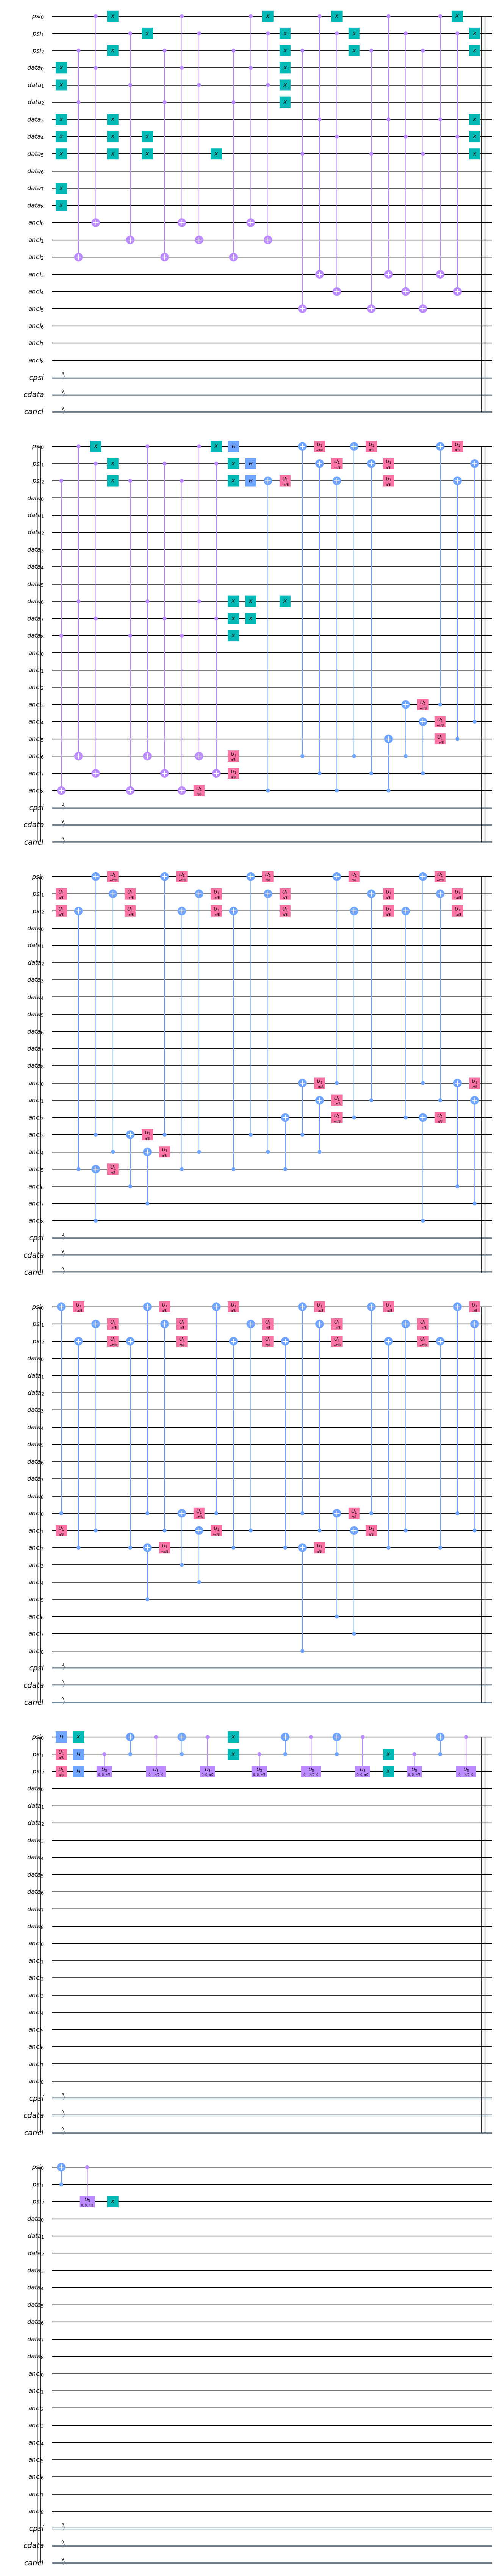

In [17]:
fig = circuit_drawer(qc, output='mpl')
fig

In [63]:
Aer.backends()

[<QasmSimulator('qasm_simulator') from AerProvider()>,
 <StatevectorSimulator('statevector_simulator') from AerProvider()>,
 <UnitarySimulator('unitary_simulator') from AerProvider()>,
 <PulseSimulator('pulse_simulator') from AerProvider()>]

In [18]:
res = execute(qc, Aer.get_backend('statevector_simulator'), shots=128).result()
print(res)
print(res.get_counts())

Result(backend_name='statevector_simulator', backend_version='0.4.0', date=datetime.datetime(2020, 3, 5, 2, 12, 50, 724437), header=Obj(backend_name='statevector_simulator', backend_version='0.4.0'), job_id='467f0a59-889e-4676-9150-52eea3689a87', metadata={'max_memory_mb': 3935, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken': 0.7977789670000001}, qobj_id='7532f345-c87a-4055-b987-1c642fb5ebcc', results=[ExperimentResult(data=ExperimentResultData(counts=Obj(0x0=1), statevector=array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])), header=Obj(clbit_labels=[['cpsi', 0], ['cpsi', 1], ['cpsi', 2], ['cdata', 0], ['cdata', 1], ['cdata', 2], ['cdata', 3], ['cdata', 4], ['cdata', 5], ['cdata', 6], ['cdata', 7], ['cdata', 8], ['cancl', 0], ['cancl', 1], ['cancl', 2], ['cancl', 3], ['cancl', 4], ['cancl', 5], ['cancl', 6], ['cancl', 7], ['cancl', 8]], creg_sizes=[['cpsi', 3], ['cdata', 9], ['cancl', 9]], memory_slots=21, n_qubits=21, name='maximal cliques', qreg_sizes=[['psi'

In [19]:
res.get_counts()

{'000000000 000000000 000': 1}

In [45]:
qb = QuantumRegister(2, name='qubit') # creating quantum bits
cb = ClassicalRegister(2, name='bit') # creating classical bits
qc = QuantumCircuit(qb, cb, name='circuit') # creating a quantum circuit with those bits

# all qubits start at |0> state
qc.x(qb[1]) # putting 2nd qubit in |1> state
qc.barrier()
qc.h(qb) # applying Hadamard on all qubits

qc.cx(qb[1], qb[0]) # oracle (as it's a CNOT, we're making an entanglement)

qc.h(qb[0]) # applying Hadamard on 1st qubit again
qc.measure(qb[0],cb[0])

print(qc)

res = execute(qc, Aer.get_backend('qasm_simulator'), shots=128).result()

print(res)
print(res.get_counts())

                  ░ ┌───┐┌───┐┌───┐┌─┐
qubit_0: |0>──────░─┤ H ├┤ X ├┤ H ├┤M├
            ┌───┐ ░ ├───┤└─┬─┘└───┘└╥┘
qubit_1: |0>┤ X ├─░─┤ H ├──■────────╫─
            └───┘ ░ └───┘           ║ 
   bit_0: 0 ════════════════════════╩═
                                      
   bit_1: 0 ══════════════════════════
                                      
Result(backend_name='qasm_simulator', backend_version='0.4.0', date=datetime.datetime(2020, 3, 4, 23, 36, 58, 7053), header=Obj(backend_name='qasm_simulator', backend_version='0.4.0'), job_id='8ae86da0-da3f-4006-aa9d-8250b12771fa', metadata={'max_memory_mb': 3935, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken': 0.0007033990000000001}, qobj_id='19d1f3a3-0aa6-42a8-b549-fe7ce1306ca4', results=[ExperimentResult(data=ExperimentResultData(counts=Obj(0x0=128)), header=Obj(clbit_labels=[['bit', 0], ['bit', 1]], creg_sizes=[['bit', 2]], memory_slots=2, n_qubits=2, name='circuit', qreg_sizes=[['qubit', 2]], qubit_labels=[['qubit', 0], ['

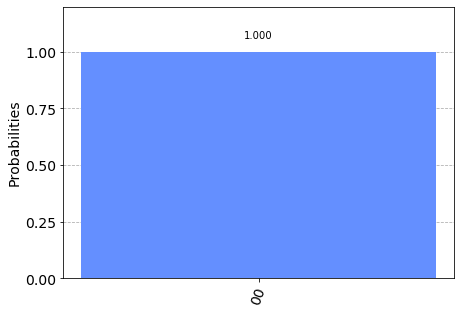

In [12]:
from qiskit.visualization import *

fig = plot_histogram([res.get_counts(qc)], bar_labels=True)
#fig.savefig('teste.png')